# End to End Multiclass Text Classification Using Deep Learning
Using the UCI ML Drug Review dataset from Kaggle

# Load libraries

In [ ]:
import pandas as pd
import numpy as np
import contractions
import re
import string
import spacy
import keras
import matplotlib.pyplot as plt
import pickle
import time
import plotly.express as px
import tensorflow as tf
import scikitplot as skplt

from tensorflow.keras import regularizers

import nltk
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from spellchecker import SpellChecker
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer

from pandas import ExcelWriter
from openpyxl import load_workbook
from collections import Counter

from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.wrappers.scikit_learn import KerasClassifier

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras import layers
from numpy import zeros
from keras.callbacks import ModelCheckpoint, EarlyStopping

from IPython.display import Image
Image("C:\\Users\\xxx\\Documents\\My_Data\\Work_Documents\\Programs\\Why.png")

import warnings
warnings.filterwarnings('ignore')

### Generic Variable Declarations

In [2]:
path            = 'C:/Users/xxx/Documents/My_Data//'
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS       = set(stopwords.words('english'))
stemmer         = PorterStemmer()
lemmatizer      = WordNetLemmatizer()
spell           = SpellChecker()
print(tf.__version__)

2.1.0


In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")
    
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Default GPU Device:/device:GPU:0
Num GPUs Available 1


## Load the Main data
It contains over 60,000 patient drug reviews for 13 unique diseaase categories

In [ ]:
data = pd.DataFrame(pd.read_excel(io='C:/Users/xxx/Documents/My_Data/Work_Documents/drugsCom.xlsx',sheet_name='All'))

data = data.dropna()
data = data.reset_index(drop=True)
print(data.shape)
data.head(3)

### Select ONLY those disease conditions whose review count are more than 1850

In [ ]:
def condition_parser(x):
    
    if x in target_conditions:
        return x
    else:
        return "OTHER"

count_df          = data[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
target_conditions = count_df[count_df['review']>1850]['condition'].values
data['condition'] = data['condition'].apply(lambda x: condition_parser(x))
data              = data[data['condition']!='OTHER']
data              = data.reset_index(drop=True)

In [ ]:
px.bar(count_df[count_df['review']>1850],x='condition',y='review') 

### Split the data into training and test set in the ratio of 80:20 and save to disk

In [ ]:
a = 0.2
test = (data.sort_values('review', ascending=False)
        .groupby('condition',group_keys=False)
        .apply(lambda x: x.head(int(len(x) * a)))
        .reset_index(drop=True))

a = 0.8
train = (data.sort_values('review', ascending=False)
        .groupby('condition',group_keys=False)
        .apply(lambda x: x.tail(int(len(x) * a)))
        .reset_index(drop=True))

writer = ExcelWriter(path + 'drugsComTrain.xlsx',engine = 'xlsxwriter')
train.to_excel(writer,sheet_name = 'train')
writer.save()
writer.close()

writer = ExcelWriter(path + 'drugsComTest.xlsx',engine = 'xlsxwriter')
test.to_excel(writer,sheet_name = 'test')
writer.save()
writer.close()

del data
del test
del train

## Load the Train data from the disk

In [ ]:
Traindata = pd.DataFrame(pd.read_excel(io=path + 'drugsComTrain.xlsx',sheet_name='train'))
Traindata = Traindata.dropna(how ='any') 
Traindata.drop('Unnamed: 0', axis=1, inplace=True)
Traindata = Traindata.reset_index(drop=True)
print(Traindata.shape)

## Load the Test dataset

In [ ]:
Testdata = pd.DataFrame(pd.read_excel(io=path + 'drugsComTest.xlsx',sheet_name='test'))
Testdata = Testdata.dropna(how='any')
Testdata.drop('Unnamed: 0', axis=1, inplace=True)
Testdata = Testdata.reset_index(drop=True)
print(Testdata.shape)

### Plot the top 10 diseases of Train data

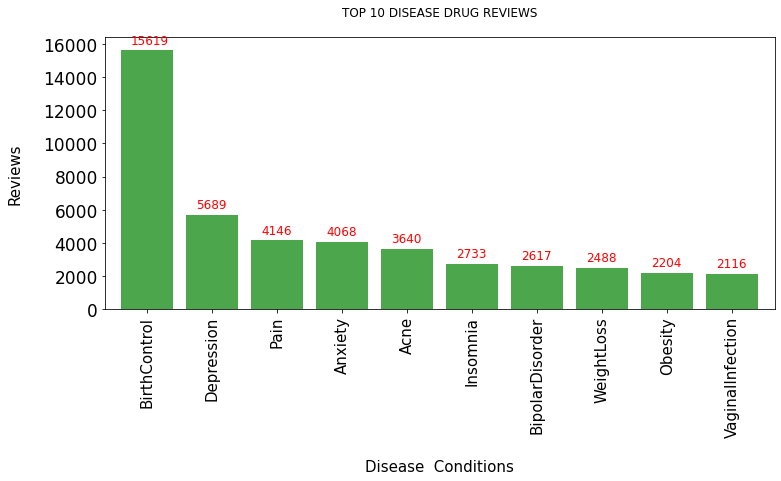

In [6]:
fig      = plt.figure(figsize=(12,5))
temp     = Traindata['condition'].value_counts()
temp     = temp.head(10)
drugList = [1,2,3,4,5,6,7,8,9,10]

temp.plot(kind = 'bar',title= 'TOP 10 DISEASE DRUG REVIEWS\n',fontsize=15, width = 0.8,color = 'green',alpha = 0.7,
          visible = 'True')

plt.ylabel('Reviews\n', fontsize = 15)
plt.xlabel('\nDisease  Conditions', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=17)

for i in range(10):
    plt.text(x = drugList[i]-1.25 , y = temp[i] + 400, s = temp[i], color = 'Red',size = 12)

## Data Preprocessing Routines

In [7]:
# Remove the new line code
def remove_newLine(text):
    text = text.replace('_x000D_\n_x000D_\n', ' ')
    text = text.replace('_x000D__x000D_\n',' ')
    return (text)

# Cleaning Special Characters and Removing Punctuation
def clean_text(x):
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, ' ', x)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text

# Remove the numbers
def remove_number(x):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, ' ', x)

# lower the text
def lowercase_text(text):
    return text.lower()

def remove_punctuation(text):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    return regex.sub(' ', text)

def remove_stopwords(text):
    return ' '.join([word for word in str(text).split() if word not in STOPWORDS])

def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r' ', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r' ', text)

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def remove_contractions(text):
    return contractions.fix(text)

def expand_contractions(text):
    return " ".join([contractions.fix(word) for word in text.split()])

def remove_extra_spaces(text):
    space_pattern = r'\s+'
    return re.sub(pattern=space_pattern, repl=" ", string=text)

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

def remove_verbwords(text):
    return ' '.join([word for word in str(text).split() if word not in skipVerbs]) 

def remove_otherwords(text):
    return ' '.join([word for word in str(text).split() if word not in skipOthers])

def remove_WordCnt_One(text):
    return ' '.join([word for word in str(text).split() if word not in WordCnt_One])


### Pre-process the Train data and Test data

In [8]:
starttime    = time.time()
corpus       = []
corpusT      = []

###########################################################################################################
#                                          Train Dataset
###########################################################################################################

Traindata["review"] = Traindata["review"].apply(lambda x: expand_contractions(x))      # Clean Contractions
Traindata["review"] = Traindata["review"].apply(lambda x: x.lower())                   # lower the text
Traindata["review"] = Traindata["review"].apply(lambda text: remove_punctuation(text)) # Removal of Punctuations
Traindata["review"] = Traindata["review"].apply(lambda x: clean_text(x))               # Clean the text
Traindata["review"] = Traindata["review"].apply(lambda x: remove_newLine(x))           # Remove new line code
Traindata["review"] = Traindata["review"].apply(lambda x: remove_stopwords(x))         # Remove stopwords
Traindata["review"] = Traindata["review"].apply(lambda x: remove_number(x))            # Remove the numbers
#Traindata["review"] = Traindata["review"].apply(lambda x: stem_words(x))               # Stemwords
#Traindata["review"] = Traindata["review"].apply(lambda x: lemmatize_words(x))          # lemmatize_words
Traindata["review"] = Traindata["review"].apply(lambda x: remove_urls(x))              # Remove URLs
Traindata["review"] = Traindata["review"].apply(lambda x: remove_html(x))              # Remove html
#Traindata["review"] = Traindata["review"].apply(lambda x: remove_contractions(x))      # Clean Contractions
#Traindata["review"] = Traindata["review"].apply(lambda x: correct_spellings(x))       # Correct spellings
Traindata["review"] = Traindata["review"].apply(lambda x: remove_extra_spaces(x))      # Remove extra expaces

#################################
# Remove less than 4 length words
#################################
for i in range(0, len(Traindata)):
    temp = re.sub(r'\b\w{1,4}\b', ' ', Traindata["review"][i])
    temp = remove_extra_spaces(temp)
    temp = temp.lstrip()
    corpus.append(temp)
    
###########################################################################################################
#                                           Test Dataset
###########################################################################################################

Testdata["review"] = Testdata["review"].apply(lambda x: expand_contractions(x))      # Clean Contractions
Testdata["review"] = Testdata["review"].apply(lambda x: x.lower())                   # lower the text
Testdata["review"] = Testdata["review"].apply(lambda text: remove_punctuation(text)) # Removal of Punctuations
Testdata["review"] = Testdata["review"].apply(lambda x: clean_text(x))               # Clean the text
Testdata["review"] = Testdata["review"].apply(lambda x: remove_newLine(x))           # Remove new line code
Testdata["review"] = Testdata["review"].apply(lambda x: remove_stopwords(x))         # Remove stopwords
Testdata["review"] = Testdata["review"].apply(lambda x: remove_number(x))            # Remove the numbers
#Testdata["review"] = Testdata["review"].apply(lambda x: stem_words(x))               # Stemwords
#Testdata["review"] = Testdata["review"].apply(lambda x: lemmatize_words(x))          # lemmatize_words
Testdata["review"] = Testdata["review"].apply(lambda x: remove_urls(x))              # Remove URLs
Testdata["review"] = Testdata["review"].apply(lambda x: remove_html(x))              # Remove html
#Testdata["review"] = Testdata["review"].apply(lambda x: remove_contractions(x))      # Clean Contractions
#Testdata["review"] = Testdata["review"].apply(lambda x: correct_spellings(x))       # Correct spellings
Testdata["review"] = Testdata["review"].apply(lambda x: remove_extra_spaces(x))      # Remove extra expaces

#################################
# Remove less than 4 length words
#################################
for i in range(0, len(Testdata)):
    temp = re.sub(r'\b\w{1,4}\b', ' ', Testdata["review"][i])
    temp = remove_extra_spaces(temp)
    temp = temp.lstrip()
    corpusT.append(temp)
      
max_train_sentence_length = max(pd.DataFrame({'Sentence': corpus}).Sentence.apply(lambda x: len(x.split())))
max_test_sentence_length  = max(pd.DataFrame({'Sentence': corpusT}).Sentence.apply(lambda x: len(x.split())))
vocab_size                = int((sum(pd.DataFrame({'Sentence': corpus}).Sentence.apply(lambda x: len(x.split()))))*.8535)

print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test  Max Sentence Length :'+str(max_test_sentence_length))
print('Total Words in Train Data :'+str(sum(pd.DataFrame({'Sentence': corpus}).Sentence.apply(lambda x: len(x.split())))))
print('Total Words in Test Data  :'+str(sum(pd.DataFrame({'Sentence': corpusT}).Sentence.apply(lambda x: len(x.split())))))
print('Vocab_size (85%) is       :'+str(vocab_size)) 
print("\nTime to Process (MIN):",round((time.time()-starttime)/60))

Train Max Sentence Length :218
Test  Max Sentence Length :309
Total Words in Train Data :1406263
Total Words in Test Data  :312371
Vocab_size (85%) is       :1200245

Time to Process (MIN): 0


### WordCloud (Train Data)

(-0.5, 1599.5, 799.5, -0.5)

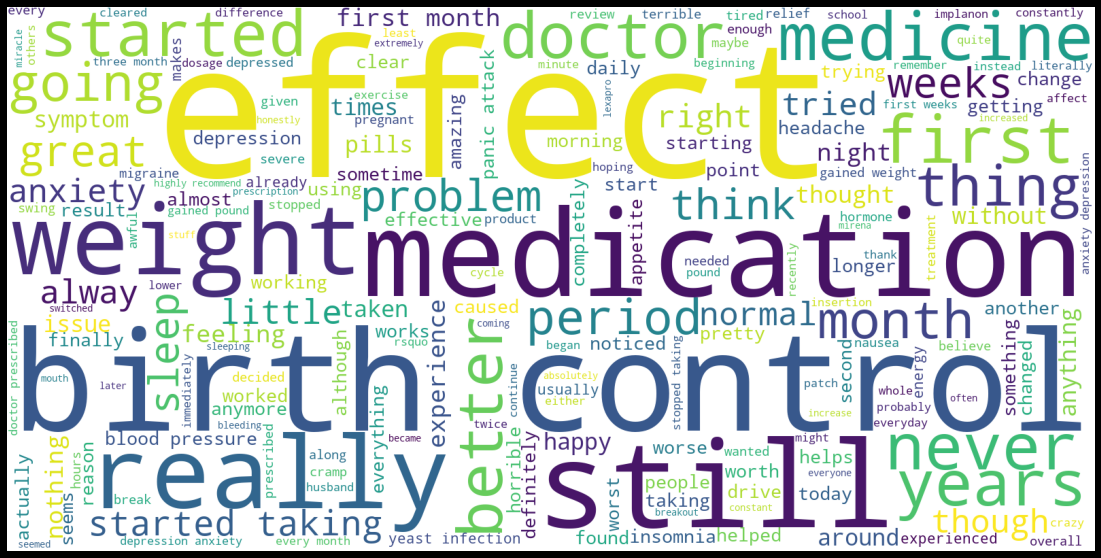

In [9]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(corpus))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")

## Split training data into train and validation datasets 
#### Convert Train, Validation and Test data into the format accepted by tensorflow. (i.e) Convert text inputs to their numeric counterparts

In [10]:
###################################################################################################
# Tokenizer class
# This class allows to vectorize text corpus, by turning each text into either sequence of integers
# Each integer being the index of a token in the dictionary
###################################################################################################
tokenizer  = Tokenizer(num_words=vocab_size,oov_token="unk") # (oov - Out of vocabulary will be 1)
tokenizer.fit_on_texts(corpus)
print(str(tokenizer.texts_to_sequences(['years hodw based are you']))) # hodw is oov. Hence replaces with 1

########################################################################################
# Split the data into training and validation set in the ratio of 80:20
# Stratification means that the train_test_split method returns training 
# and validation subsets have the same proportions of class labels as the input dataset
########################################################################################
train_data, validation_data, train_label, validation_label  = train_test_split(corpus, Traindata['condition'].tolist(),
                                                                               test_size=0.2, stratify = Traindata['condition'].tolist(),
                                                                               random_state=0)
print('\nTrain data Sentences:'+str(len(train_data)))
print('\nClass distribution'+str(Counter(train_label)))
print('\nValid data Sentences:'+str(len(validation_data)))
print('\nClass distribution'+ str(Counter(validation_label)))

####################################################
# Integer encode the sentences using Tokenizer class
####################################################
train_data        = np.array(tokenizer.texts_to_sequences(train_data))
validation_data   = np.array(tokenizer.texts_to_sequences(validation_data))
test_data         = np.array(tokenizer.texts_to_sequences(corpusT))

###########################################################################
# padding encoded text to a max length to have all vectors the same length 
###########################################################################   
max_sentence_length = max_train_sentence_length if (max_train_sentence_length > max_test_sentence_length) else max_test_sentence_length
train_data          = pad_sequences(train_data, padding='post', maxlen=max_sentence_length)
validation_data     = pad_sequences(validation_data, padding='post', maxlen=max_sentence_length)
test_data           = pad_sequences(test_data, padding='post', maxlen=max_sentence_length)

#####################################################################################
# Label Encode the class labels(Target) to numbers of train/validation/test data sets
#####################################################################################
le                = LabelEncoder()
train_label       = le.fit_transform(train_label)
classCount        = len(set(train_label))
validation_label  = le.fit_transform(validation_label)
test_label        = le.fit_transform(Testdata['condition'].tolist())

#########################################################
# Now create tensorflow dataset by joining data and label
#########################################################

train_ds = tf.data.Dataset.from_tensor_slices((train_data,train_label))
valid_ds = tf.data.Dataset.from_tensor_slices((validation_data,validation_label))
test_ds  = tf.data.Dataset.from_tensor_slices((test_data,test_label))

[[5, 1, 1070, 1, 1]]

Train data Sentences:40444

Class distributionCounter({'BirthControl': 12495, 'Depression': 4551, 'Pain': 3317, 'Anxiety': 3254, 'Acne': 2912, 'Insomnia': 2187, 'BipolarDisorder': 2094, 'WeightLoss': 1990, 'Obesity': 1763, 'VaginalInfection': 1693, 'ADHD': 1544, 'HighBP': 1458, 'DiabetesType2': 1186})

Valid data Sentences:10111

Class distributionCounter({'BirthControl': 3124, 'Depression': 1138, 'Pain': 829, 'Anxiety': 814, 'Acne': 728, 'Insomnia': 546, 'BipolarDisorder': 523, 'WeightLoss': 498, 'Obesity': 441, 'VaginalInfection': 423, 'ADHD': 386, 'HighBP': 364, 'DiabetesType2': 297})


### How data looks now

In [11]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor(
[68 18 15  4 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(309,), dtype=in

# Neural network Hyperparameter Tuning

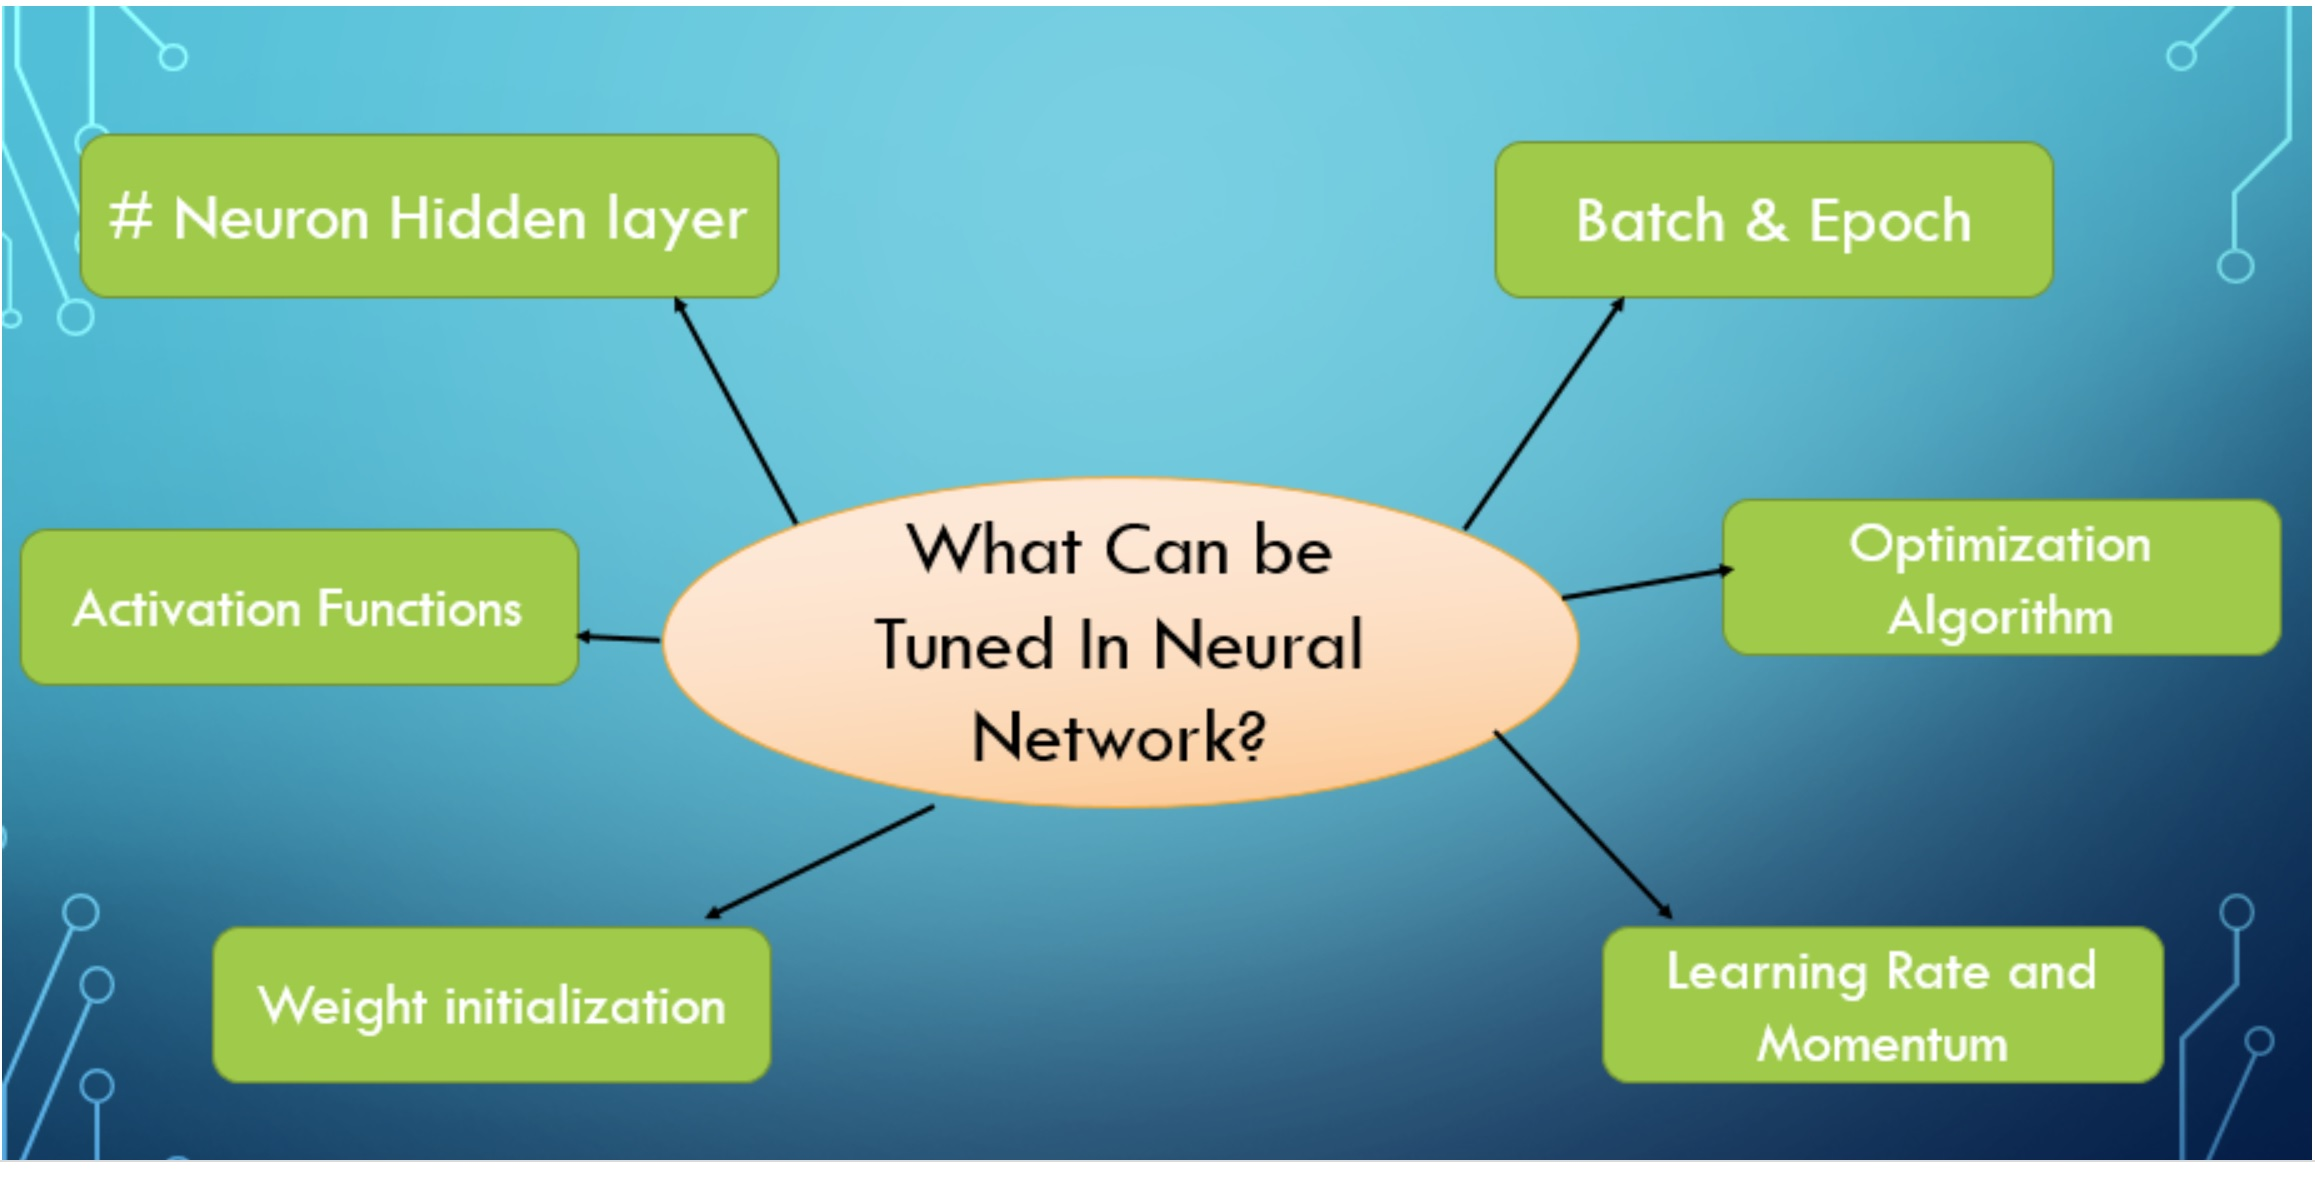

In [12]:
Image("C:\\Users\\xxx\\Documents\\My_Data\\Work_Documents\\Programs\\tuning.jpg")

### Tuning epoch

### Tuning Optimization Algorithm

### Tuning learning rate

### Tune Network Weight Initialization

### Tune the Neuron Activation Function

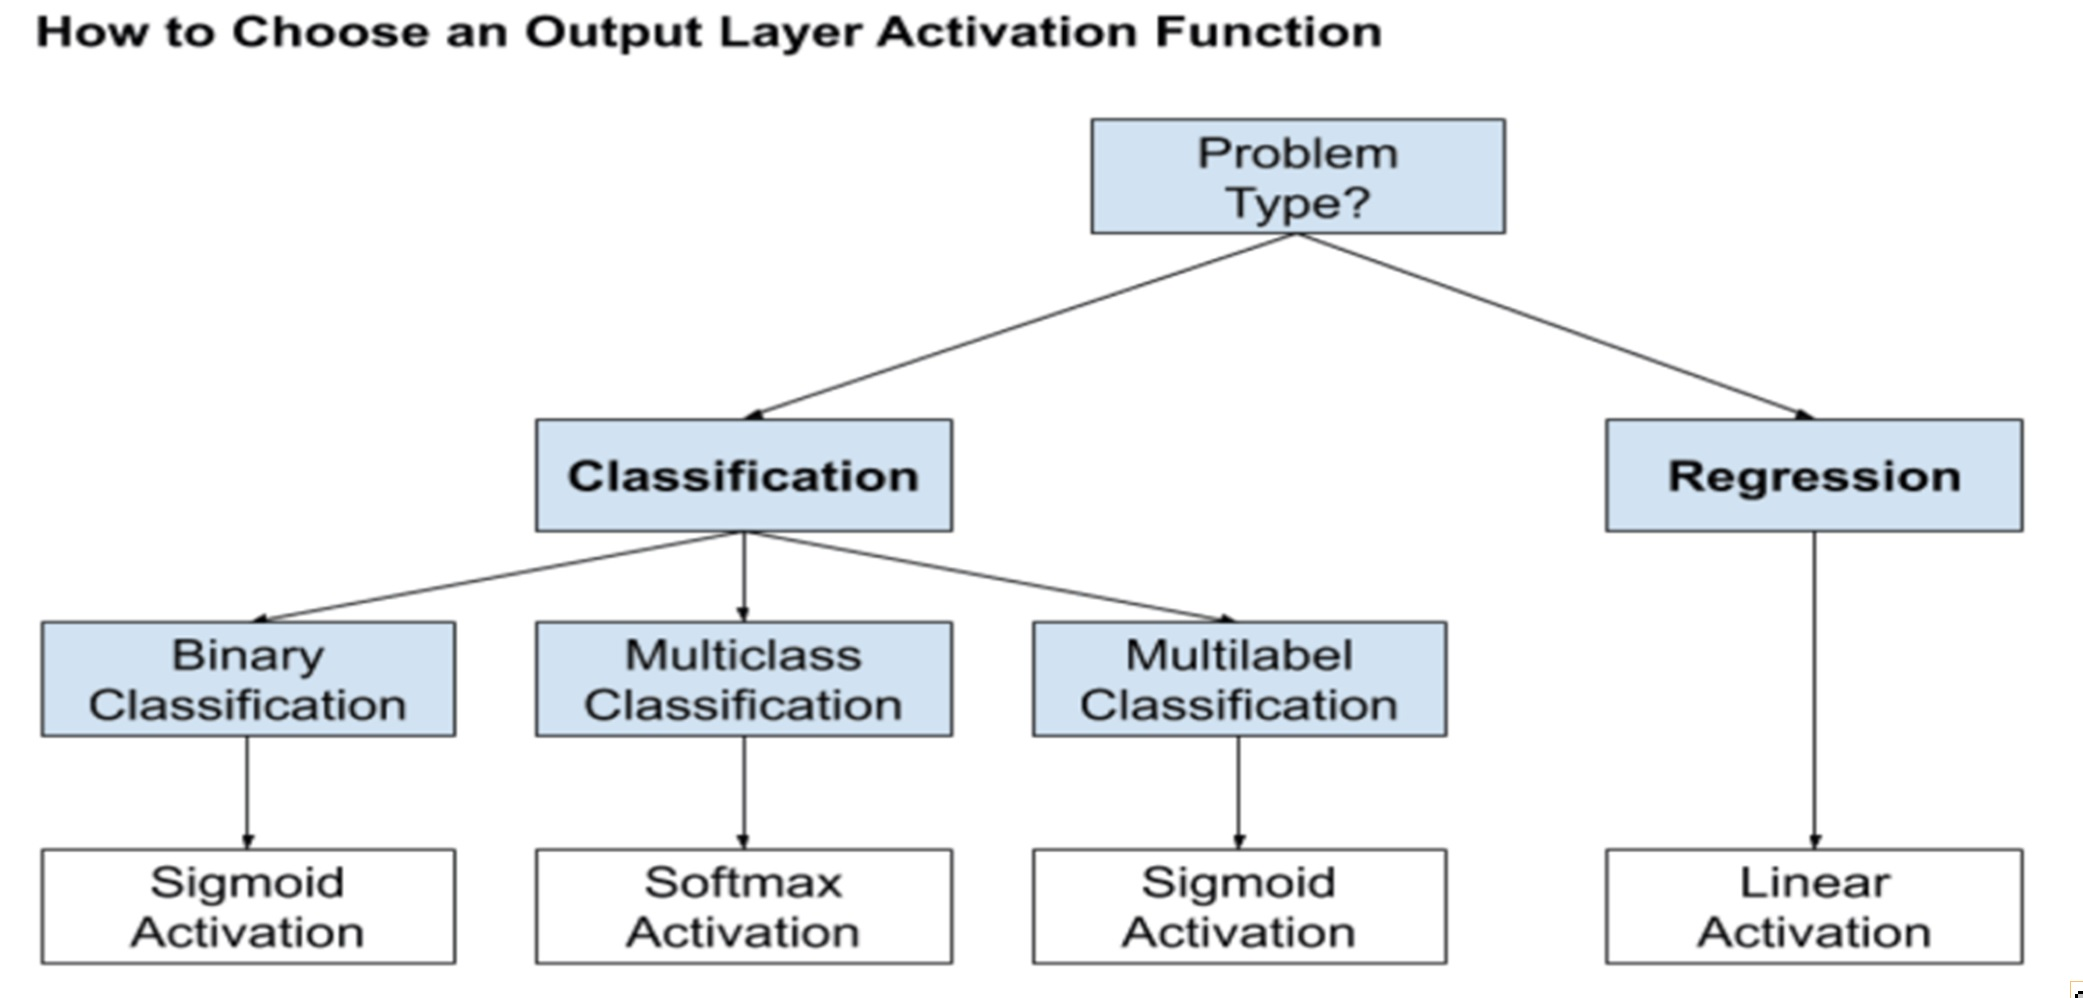

In [13]:
Image("C:\\Users\\xxx\\Documents\\My_Data\\Work_Documents\\activation_function.jpg")

### Tune Dropout Regularization

### Weight Regularization Tuning

## Deep Learning Model with Keras

In [ ]:
embedding_dim       = 64 
epochs              = 15
Dropout             = 0.3
weight              = 0.000004
Opt                 = tf.keras.optimizers.Adam(lr=0.001)
eS                  = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1,restore_best_weights = True) # Early stopping to prevent overfitting

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = vocab_size + 1, output_dim = embedding_dim, input_length=max_sentence_length,
                                    embeddings_regularizer = regularizers.l2(weight)))                                    

model.add(tf.keras.layers.Conv1D(filters = 128, kernel_size= 3, kernel_initializer = 'glorot_uniform', 
                                 activation='relu',
                                 kernel_regularizer = regularizers.l2(weight),
                                 bias_regularizer = regularizers.l2(weight)))                               

model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(Dropout)) # Randomly removes Dropout% of the units from each layer

model.add(tf.keras.layers.Dense(units = classCount, kernel_initializer = 'glorot_uniform',
                                activation='softmax',
                                kernel_regularizer=regularizers.l2(weight),\
                                bias_regularizer=regularizers.l2(weight),))

print(model.summary())
model.compile(optimizer = Opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy']) 

###############
# fit the model
###############
mymodel = model.fit(train_ds.shuffle(2000).batch(128), epochs= epochs, validation_data=valid_ds.batch(128), verbose=1,
                    callbacks=[eS])

####################
# evaluate the model
####################
loss, accuracy  = model.evaluate(train_data, train_label, verbose=False)
loss, valid_acc = model.evaluate(validation_data, validation_label, verbose=0)
print('Training Accuracy  : %f' % (accuracy*100))
print('Validation Accuracy: %f' % (valid_acc*100))

################
# Save the model
################
model.save("C:/Users/xxx/Documents/My_Data/Work_Documents")

# Embedding Layer Functionality Pictorial Representation

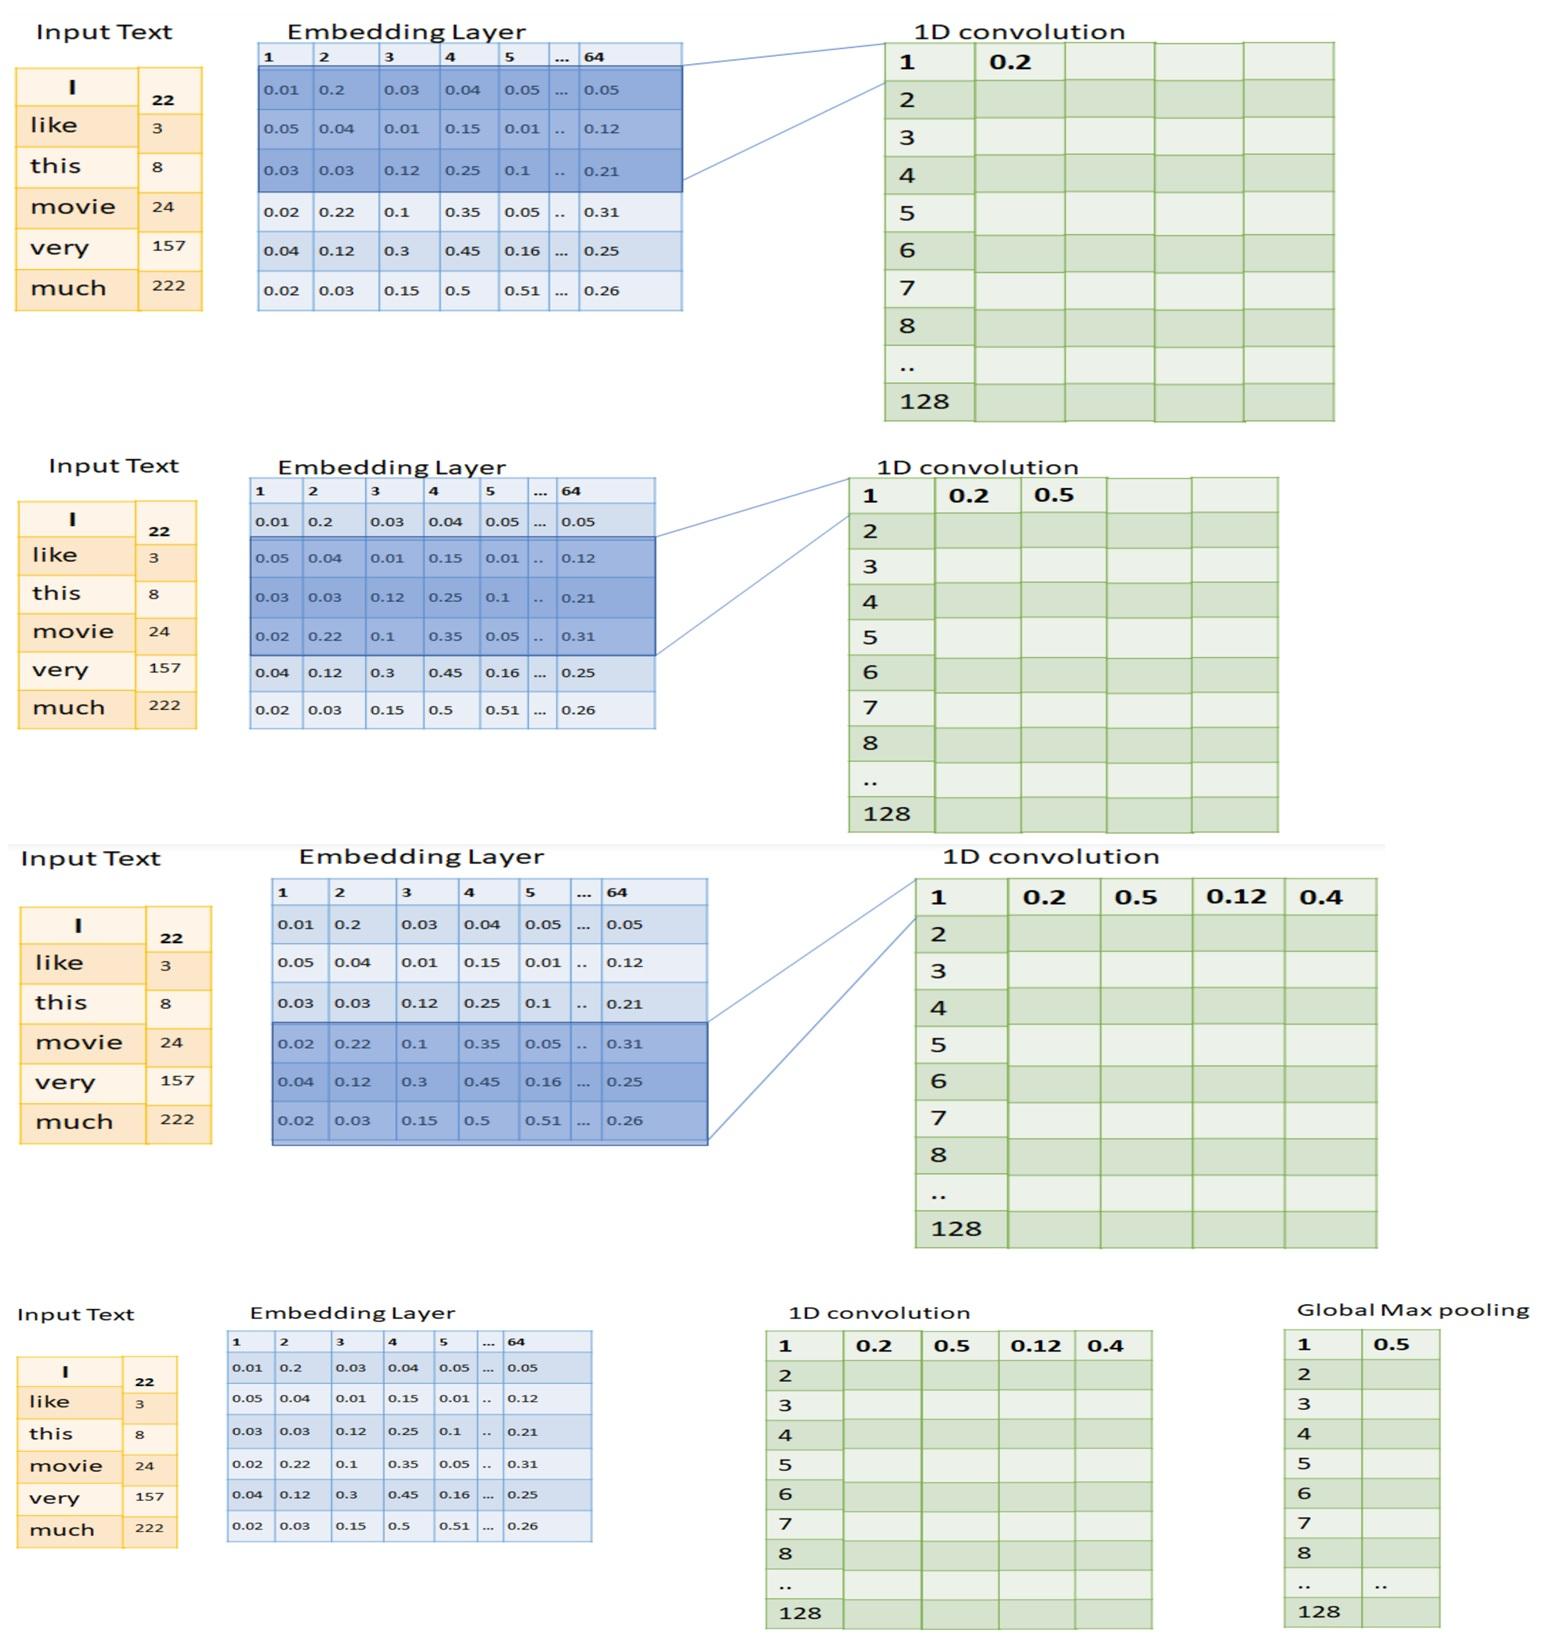

In [15]:
Image("C:\\Users\\xxx\\Documents\\My_Data\\Work_Documents\\Embedding_layer_functionality.jpg")

## Plot of Train and Validation Loss Simple Early Stopping

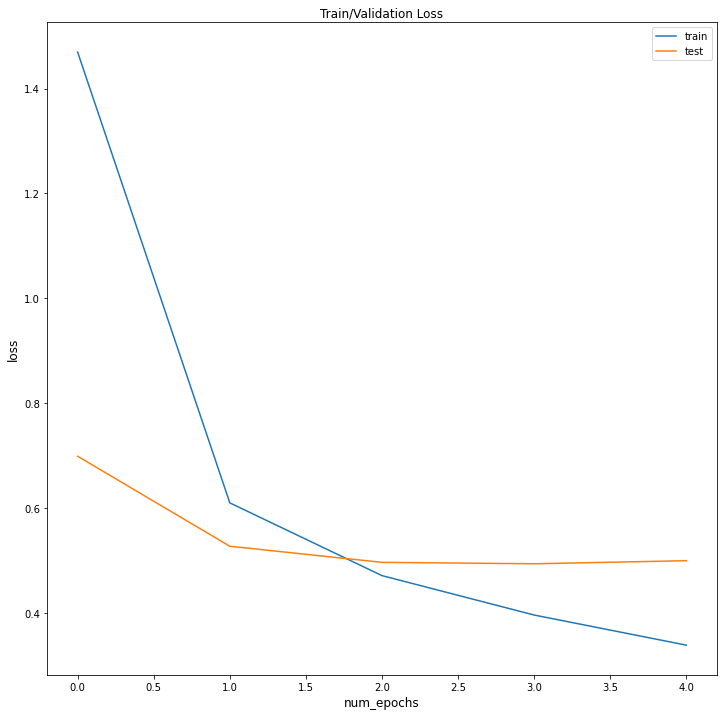

In [23]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(mymodel.history['loss'], label='train')
    plt.plot(mymodel.history['val_loss'], label='test')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend()
    plt.show()
plot_graph(6)

## Load the saved model

In [17]:
classifier = tf.keras.models.load_model("C:/Users/xxx/Documents/My_Data/Work_Documents")

## Predictions on unseen data (Test Data)

In [18]:
y_true     = [le.classes_[x] for x in test_label]
test_preds = classifier.predict_classes(test_data)
y_pred     = [le.classes_[x] for x in test_preds]

loss, accuracy = model.evaluate(test_data, test_label, verbose=False)
print('Test Accuracy: %f' % (accuracy*100))

Test Accuracy: 78.884053


## Plot confusion matrix

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

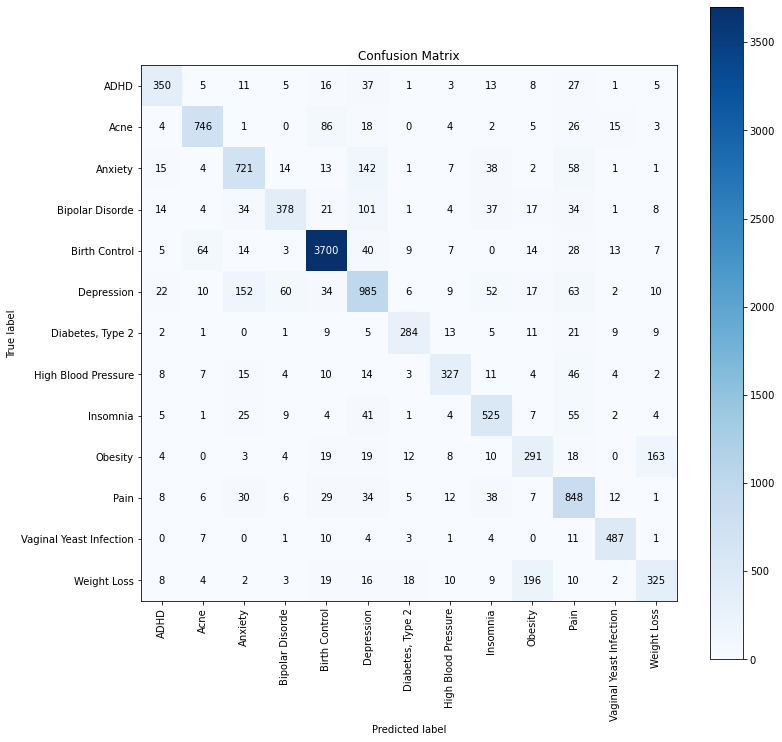

In [24]:
skplt.metrics.plot_confusion_matrix(y_true,y_pred,figsize=(12,12),x_tick_rotation=90)

## Predict Standalone Review

In [21]:
def predict_review(x):    
    
    x = expand_contractions(x)
    x = x.lower()
    x = remove_punctuation(x)
    x = clean_text(x)
    x = remove_newLine(x)
    x = remove_stopwords(x)
    x = remove_number(x)
    x = stem_words(x)
    #x = lemmatize_words(x)
    x = remove_urls(x)
    x = remove_html(x)
    #x = remove_contractions(x)
    x = remove_extra_spaces(x)
    x = re.sub(r'\b\w{1,4}\b', ' ', x) # Remove less than 4 length words
    x = tokenizer.texts_to_sequences([x])
    x = pad_sequences(x, padding='post', maxlen=max_sentence_length)
    pred = classifier.predict_classes(x)
    pred = le.classes_[pred]
    return pred[0]

In [22]:
x = Traindata['review'][266]
print(predict_review(x))
x = Traindata['review'][21448]
print(predict_review(x))
x = Traindata['review'][29955]
print(predict_review(x))
x = Testdata['review'][12634]
print(predict_review(x))

ADHD
Birth Control
Depression
Obesity
